In [5]:
import sys

curr_ld_lib_path = ''

from metatlas import metatlas_objects as metob
from metatlas import h5_query as h5q

import qgrid

from matplotlib import pyplot as plt
import pandas as pd
import os
import tables
import pickle
%matplotlib inline


import dill

import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
# from rdkit.Chem.rdMolDescriptors import ExactMolWt
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG,display

/home/jimmy/anaconda2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [7]:
# my_file = 'save_data_pos_exudates_only.pkl'
# my_file = 'save_data_neg_exudates_only.pkl'
# my_file = 'save_data_pos_cassettes.pkl'

my_file = '/home/jimmy/Downloads/20160119_KZ_Negative_QE_HILIC_Avena_Uptake.pkl'
# my_file = 'save_data_neg_archetypes_hilic.pkl'
# my_file = 'save_data_pos_archetypes_hilic_istds.pkl'
# project_label = 'kate_exudates_metatlas_exudates_neg_only'
project_label = '20160119_KZ_Positive_QE_HILIC_Avena_Uptake'

with open(my_file,'r') as f:
    data = dill.load(f)

In [8]:
# pos_data = []
# neg_data = []
# for d in data:
#     if len(d) == 64:
#         pos_data.append(d)
#     if len(d) == 47:
#         neg_data.append(d)
# data = pos_data

In [9]:
print data[1][1].keys()
print data[1][1]['data'].keys()
print len(data[0])

['group', 'identification', 'lcmsrun', 'data']
['eic', 'ms1_summary', 'msms']
109


In [10]:
data[0][0]['data']

{'eic': {'intensity': array([  5372.39550781,   6616.77246094,   9269.71679688,   7738.67382812,
           6528.78125   ,   6897.85546875,   5295.9453125 ,   9683.76953125,
          10760.18359375,   6761.2421875 ,   8640.1796875 ,  10655.046875  ,
           7497.0546875 ,  11534.4296875 ,   6848.0546875 ,   7738.8828125 ,
          11288.5625    ,   7289.03125   ,  10882.125     ,   7489.34375   ,
           7028.40625   ,   7727.09375   ,   9543.359375  ,   6570.21875   ,
           7665.375     ,   7070.1875    ,   8798.609375  ,   7131.890625  ,
           7859.265625  ,   7364.6875    ,   6614.5       ,   8315.484375  ,
           9051.1875    ,  11086.71875   ,   7153.4375    ,  10023.5625    ,
           9393.84375   ,   8824.9375    ,   7984.875     ,   7409.0625    ,
           8446.0625    ,   5872.6875    ,   7324.96875   ,   6827.1875    ,
           5480.75      ,   6470.8125    ,   7940.25      ,  10841.25      ,
           9256.4375    ,   8887.5625    ,   7920.375   

In [11]:
import re
export_group_names = []
for i,d in enumerate(data):
    newstr = d[0]['group'].name
    export_group_names.append(newstr)
print len(export_group_names)

75


In [12]:
import re
export_file_names = []
for i,d in enumerate(data):
    newstr = os.path.basename(d[0]['lcmsrun'].hdf5_file)
    export_file_names.append(newstr)
print len(export_file_names)

75


In [18]:
import re
from collections import defaultdict

export_compound_names = []
export_compound_objects = []
for i,d in enumerate(data[0]):
    # if label: use label
    # else if compound: use compound name
    # else no name
    export_compound_objects.append(d['identification'])
    if len(d['identification'].compound) > 0:
        str = d['identification'].compound[0].name
    else:
        str = d['identification'].name
    newstr = '%s_%s_%s_%5.2f'%(str,d['identification'].mz_references[0].detected_polarity,d['identification'].mz_references[0].adduct,d['identification'].rt_references[0].rt_peak)
    newstr = re.sub('\.', 'p', newstr) #2 or more in regexp

    newstr = re.sub('[\[\]]','',newstr)
    newstr = re.sub('[^A-Za-z0-9+-]+', '_', newstr)
    newstr = re.sub('i_[A-Za-z]+_i_', '', newstr)
    if newstr[0] == '_':
        newstr = newstr[1:]
    if newstr[0] == '-':
        newstr = newstr[1:]
    if newstr[-1] == '_':
        newstr = newstr[:-1]

    newstr = re.sub('[^A-Za-z0-9]{2,}', '', newstr) #2 or more in regexp
    export_compound_names.append(newstr)

#If duplicate compound names exist, then append them with a number
D = defaultdict(list)
for i,item in enumerate(export_compound_names):
    D[item].append(i)
D = {k:v for k,v in D.items() if len(v)>1}
for k in D.keys():
    for i,f in enumerate(D[k]):
        export_compound_names[f] = '%s%d'%(export_compound_names[f],i)

#for i, e in enumerate (export_compound_names):
#    print i,e
#print len(export_compound_names)
export_compound_names[1]

u'2-oxovalerate_negative_3p40'

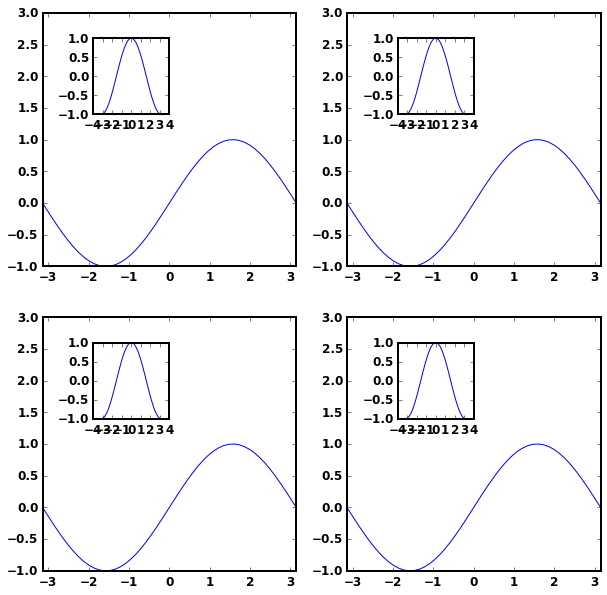

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def axis_to_fig(axis):
    fig = axis.figure
    def transform(coord):
        return fig.transFigure.inverted().transform(
            axis.transAxes.transform(coord))
    return transform

def add_sub_axes(axis, rect):
    fig = axis.figure
    left, bottom, width, height = rect
    trans = axis_to_fig(axis)
    figleft, figbottom = trans((left, bottom))
    figwidth, figheight = trans([width,height]) - trans([0,0])
    return fig.add_axes([figleft, figbottom, figwidth, figheight])

x = np.linspace(-np.pi,np.pi)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
plt.setp(ax, 'frame_on', False)

for axis in axes.ravel():
    axis.set_xlim(-np.pi, np.pi)
    axis.set_ylim(-1, 3)
    axis.plot(x, np.sin(x))
    subaxis = add_sub_axes(axis, [0.2, 0.6, 0.3, 0.3])
    subaxis.plot(x, np.cos(x))

plt.show()


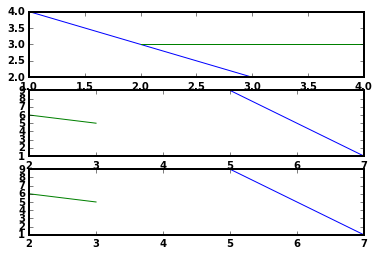

In [31]:
from matplotlib import pyplot as PLT

fig = PLT.figure()

ax = fig.add_subplot(311)
ax.plot([(1, 2), (3, 4)], [(4, 3), (2, 3)])
ax = fig.add_subplot(312)
ax.plot([(7, 2), (5, 3)], [(1, 6), (9, 5)])
ax = fig.add_subplot(313)
ax.plot([(7, 2), (5, 3)], [(1, 6), (9, 5)])
PLT.show()


In [53]:
print product(range(0, 10), repeat=2)

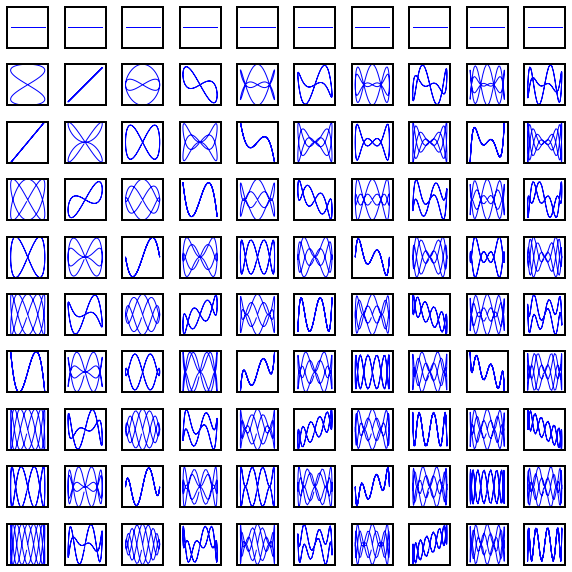

In [51]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

from itertools import product


def squiggle_xy(a, b, c, d, i=np.arange(0.0, 2*np.pi, 0.05)):
    return np.sin(i*a)*np.cos(i*b), np.sin(i*c)*np.cos(i*d)

fig = plt.figure(figsize=(10, 10))

# gridspec inside gridspec
outer_grid = gridspec.GridSpec(1, 1, wspace=0.0, hspace=0.0)

i = 0
inner_grid = gridspec.GridSpecFromSubplotSpec(10, 10,
            subplot_spec=outer_grid[i], wspace=0.4, hspace=0.4)
a, b = int(i/4)+1,i%4+1
for j, (c, d) in enumerate(product(range(0, 10), repeat=2)):
    ax = plt.Subplot(fig, inner_grid[j])
    ax.plot(*squiggle_xy(a, b, c, d))
    ax.set_xticks([])
    ax.set_yticks([])
    fig.add_subplot(ax)

all_axes = fig.get_axes()

#show only the outside spines
for ax in all_axes:
    for sp in ax.spines.values():
        sp.set_visible(True)
    if ax.is_first_row():
        ax.spines['top'].set_visible(True)
    if ax.is_last_row():
        ax.spines['bottom'].set_visible(True)
    if ax.is_first_col():
        ax.spines['left'].set_visible(True)
    if ax.is_last_col():
        ax.spines['right'].set_visible(True)

plt.show()

In [ ]:
def plot_chromatogram(d,file_name, ax=None):
    import numpy as np
    from textwrap import wrap
    if ax is None:
        ax = plt.gca()

    plt.rcParams['pdf.fonttype']=42
    plt.rcParams['pdf.use14corefonts'] = True
    plt.rcParams['text.usetex'] = False
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'font.weight': 'bold'})
    plt.rcParams['axes.linewidth'] = 2 # set the value globally

    rt_min = d['identification'].rt_references[0].rt_min
    rt_max = d['identification'].rt_references[0].rt_max
    rt_peak = d['identification'].rt_references[0].rt_peak
        
    if len(d['data']['eic']['rt']) > 0:
        x = d['data']['eic']['rt']
        y = d['data']['eic']['intensity']
        ax.plot(x,y,'k-',linewidth=2.0,alpha=1.0)  
        myWhere = np.logical_and(x>=rt_min, x<=rt_max )
        ax.fill_between(x,0,y,myWhere, facecolor='c', alpha=0.3)

    ax.axvline(rt_min, color='k',linewidth=2.0)
    ax.axvline(rt_max, color='k',linewidth=2.0)
    ax.axvline(rt_peak, color='r',linewidth=2.0)
#     ax.set_xlabel('Time (min)',weight='bold')
#     ax.set_ylabel('Intensity (au)',weight='bold')

In [ ]:
  def plot_all_compounds_for_each_file(data,nCols,export_file_names,export_compound_names,share_y,project_label):
    import time
    nRows = int(np.ceil(len(export_compound_names)/float(nCols)))
    
    
    d = 'data/%s/one_file_chromatograms/'%project_label
    print d
    
    if not os.path.exists(d):
        os.makedirs(d)

    for file_idx,my_file in enumerate(export_file_names):
        f, ax = plt.subplots(nRows, nCols, sharey=share_y,figsize=(8*nCols,nRows * 6)) #original 8 x 6
#         plt.tight_layout()
        ax = ax.flatten()
        
        parttime = time.time()

        for i,compound in enumerate(export_compound_names):
            p = plot_chromatogram(data[file_idx][i], compound, ax=ax[i])
        
        print time.time() - parttime
        parttime = time.time()
        f.savefig('%s%s.pdf'%(d,export_file_names[file_idx]))
        print time.time() - parttime
        parttime = time.time()
        plt.close('all')#f.clear()
        print time.time() - parttime  ax.set_title("\n".join(wrap(file_name,54)),fontsize=12,weight='bold')

In [14]:
def plot_all_chromatograms_all_files(data,nCols,export_file_names,export_compound_names,share_y,project_label):
    import time
    d = 'data/%s/chromatograms/'%project_label
    if not os.path.exists(d):
        os.makedirs(d)
    nRows = int(np.ceil(len(export_file_names)/float(nCols)))
    for compound_idx,compound in enumerate(export_compound_names):
        starttime = time.time()
        f, ax = plt.subplots(nRows, nCols, sharey=share_y,figsize=(8*nCols,nRows * 6)) #original 8 x 6
        parttime = time.time()
        print partime - starttime
        break
#         plt.tight_layout()
        print "figure created in ", time.time() - starttime, " seconds"
        ax = ax.flatten()
        parttime = time.time()
        for i,fname in enumerate(export_file_names):
            p = plot_chromatogram(data[i][compound_idx], fname, ax=ax[i])
        print i, "subplots created in ", time.time() - parttime, " seconds"
#         parttime = time.time()
#         print "tight layout is ", time.time() - parttime, " seconds"
        parttime = time.time()
        f.savefig('%s%s.pdf'%(d,export_compound_names[compound_idx]))
        print "time to save figure is ", time.time() - parttime, " seconds"
        parttime = time.time()
#         f.clear()
        plt.close('all')#f.clear()
        print "time to clear and close figure is ", time.time() - parttime, " seconds"
        print " "

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
K_max = 20
K_min = 0
L_max = 20
L_min = 0
ax = plt.subplot(111)
x_offset = 7 # tune these
y_offset = 7 # tune these
plt.setp(ax, 'frame_on', False)
ax.set_ylim([0, (K_max-K_min +1)*y_offset ])
ax.set_xlim([0, (L_max - L_min+1)*x_offset])
ax.set_xticks([])
ax.set_yticks([])
ax.grid('off')



for k in np.arange(K_min, K_max + 1):
    for l in np.arange(L_min, L_max + 1):
        ax.plot(np.arange(5) + l*x_offset, 5+np.random.rand(5) + k*y_offset,
                'r-o', ms=1, mew=0, mfc='r')
        ax.plot(np.arange(5) + l*x_offset, 3+np.random.rand(5) + k*y_offset,
                'b-o', ms=1, mew=0, mfc='b')
        ax.annotate('K={},L={}'.format(k, l), (2.5+ (k)*x_offset,l*y_offset), size=3,ha='center')
plt.savefig(os.path.join(os.getcwd(), 'plot-average.pdf'))

print 'Final plot created.'

In [ ]:
def plot_chromatogram(d,file_name, , x_offset, y_offset, ax=None):
    import numpy as np
    from textwrap import wrap
    if ax is None:
        ax = plt.gca()

    plt.rcParams['pdf.fonttype']=42
    plt.rcParams['pdf.use14corefonts'] = True
    plt.rcParams['text.usetex'] = False
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'font.weight': 'bold'})
    plt.rcParams['axes.linewidth'] = 2 # set the value globally

    rt_min = d['identification'].rt_references[0].rt_min
    rt_max = d['identification'].rt_references[0].rt_max
    rt_peak = d['identification'].rt_references[0].rt_peak
        
    if len(d['data']['eic']['rt']) > 0:
        x = d['data']['eic']['rt']+x_offset
        y = d['data']['eic']['intensity']
        ax.plot(x+x_offset, y+y_ofset,'k-',linewidth=2.0,alpha=1.0)  
        myWhere = np.logical_and(x>=rt_min, x<=rt_max )
        ax.fill_between(x+x_offset,0,y+y_offset,myWhere, facecolor='c', alpha=0.3)

    ax.axvline(rt_min, color='k',linewidth=2.0)
    ax.axvline(rt_max, color='k',linewidth=2.0)
    ax.axvline(rt_peak, color='r',linewidth=2.0)
#     ax.set_xlabel('Time (min)',weight='bold')
#     ax.set_ylabel('Intensity (au)',weight='bold')

    ax.set_title("\n".join(wrap(file_name,54)),fontsize=12,weight='bold')

In [14]:
def plot_all_compounds_for_each_file(data,nCols,export_file_names,export_compound_names,share_y,project_label):
    import time
    
    nRows = int(np.ceil(len(export_compound_names)/float(nCols)))
    
    K_max = nRows
    K_min = 0
    L_max = nCols
    L_min = 0
    
    x_offset = 7 # tune these
    y_offset = 7 # tune these
    
    
    d = 'data/%s/one_file_chromatograms/'%project_label
    print d
    
    if not os.path.exists(d):
        os.makedirs(d)
    
    
    
    
    for file_idx,my_file in enumerate(export_file_names):
        del ax
        ax = plt.subplot(111)
        plt.setp(ax, 'frame_on', False)
        ax.set_ylim([0, (K_max-K_min +1)*y_offset ])
        ax.set_xlim([0, (L_max - L_min+1)*x_offset])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid('off')

        counter = 0
        for i in range(nRows):
            for j in range(nCols):
                p = plot_chromatogram(data[file_idx][counter], compound, i*y_offset, j*x_offset, ax)
                counter += 1
        
        f.savefig('%s%s.pdf'%(d,export_file_names[file_idx]))
        print time.time() - parttime
        parttime = time.time()
        plt.close('all')#f.clear()
        print time.time() - parttime

In [14]:
nCols = 9
share_y=False
plot_all_compounds_for_each_file(data,nCols,export_file_names,export_compound_names,share_y,project_label)

data/20160119_KZ_Positive_QE_HILIC_Avena_Uptake/one_file_chromatograms/
0.714494943619
13.0051620007
0.000128984451294
0.895073890686
16.0926239491
0.0017409324646
2.27303600311
18.6972179413
0.0002601146698
0.889434099197
13.0432431698
0.00145196914673
0.891710996628


KeyboardInterrupt: 

KeyboardInterrupt: 

In [ ]:
""" contribution from Hans de Winter """
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
#     mol = Chem.MolFromSmiles(smiles)
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = AllChem.ReplaceSubstructs(mol, reactant, product)
            rms_smiles = Chem.MolToSmiles(rms[0])
            mol = Chem.MolFromSmiles(rms_smiles)
    if replaced:
        return (mol, True) #Chem.MolToSmiles(mol,True)
    else:
        return (mol, False)
def drawStructure_ShowingFragment(pactolus_tree,fragment_idx,myMol,myMol_w_Hs):

    drawer = rdMolDraw2D.MolDraw2DSVG(600,300)

    fragment_atoms = np.where(pactolus_tree[fragment_idx]['atom_bool_arr'])[0]
    mark_atoms_no_H = []
    for a_index in fragment_atoms:
        if myMol_w_Hs.GetAtomWithIdx(a_index).GetSymbol() != 'H':
            mark_atoms_no_H.append(a_index)

    rdDepictor.Compute2DCoords(myMol)

    drawer.DrawMolecule(myMol,highlightAtoms=mark_atoms_no_H)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText().replace('svg:','')
    return svg

def drawStructure_Fragment(pactolus_tree,fragment_idx,myMol,myMol_w_Hs):
    fragment_atoms = np.where(pactolus_tree[fragment_idx]['atom_bool_arr'])[0]
    depth_of_hit = np.sum(pactolus_tree[fragment_idx]['bond_bool_arr'])
    mol2 = deepcopy(myMol_w_Hs)
    # Now set the atoms you'd like to remove to dummy atoms with atomic number 0
    fragment_atoms = np.where(pactolus_tree[fragment_idx]['atom_bool_arr']==False)[0]
    for f in fragment_atoms:
        mol2.GetAtomWithIdx(f).SetAtomicNum(0)

    # Now remove dummy atoms using a query
    mol3 = Chem.DeleteSubstructs(mol2, Chem.MolFromSmarts('[#0]'))
    mol3 = Chem.RemoveHs(mol3)
    # You get what you are looking for
    return moltosvg(mol3),depth_of_hit


def moltosvg(mol,molSize=(450,150),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    return svg.replace('svg:','')

def get_ion_from_fragment(frag_info,spectrum):
    hit_indices = np.where(np.sum(frag_info,axis=1))
    hit = spectrum[hit_indices,:][0]
    return hit,hit_indices

In [ ]:
#plot msms and annotate
#compound name
#formula
#adduct
#theoretical m/z
#histogram of retention times
#scatter plot of retention time with peak area
#retention time
#print all chromatograms
#structure

def file_with_max_precursor_intensity(data,compound_idx):
    idx = []
    my_max = 0
    for i,d in enumerate(data):
        temp = d[compound_idx]['data']['msms']['data']
        if d[compound_idx]['data']['msms']['polarity'] or d[compound_idx]['data']['msms']['polarity'] ==0 :
            m = np.max(temp['precursor_intensity'])
            if m > my_max:
                my_max = m
                idx = i
    return idx,my_max


def make_identification_figure(data,file_idx,compound_idx,export_name,project_label):
    d = 'data/%s/identification/'%project_label
    if not os.path.exists(d):
        os.makedirs(d)
    fig = plt.figure(figsize=(20,20))
#     fig = plt.figure()
    ax = fig.add_subplot(211)
    ax.set_title(export_name,fontsize=12,weight='bold')
    ax.set_xlabel('m/z',fontsize=12,weight='bold')
    ax.set_ylabel('intensity',fontsize=12,weight='bold')

    mz = data[file_idx][compound_idx]['data']['msms']['data']['mz']
    zeros = np.zeros(data[file_idx][compound_idx]['data']['msms']['data']['mz'].shape)
    intensity = data[idx][compound_idx]['data']['msms']['data']['i']
    ax.vlines(mz,zeros,intensity,colors='r',linewidth = 2)
    sx = np.argsort(intensity)[::-1]
    labels = [1.001e9]
    for i in sx:
        if np.min(np.abs(mz[i] - labels)) > 0.1 and intensity[i] > 0.02 * np.max(intensity):
            ax.annotate('%5.4f'%mz[i], xy=(mz[i], 1.01*intensity[i]),rotation = 90, horizontalalignment = 'center', verticalalignment = 'left')
            labels.append(mz[i])

    plt.tight_layout()
    L = plt.ylim()
    plt.ylim(L[0],L[1]*1.12)
    if data[file_idx][compound_idx]['identification'].compound:
        inchi =  data[file_idx][compound_idx]['identification'].compound[0].inchi
        myMol = Chem.MolFromInchi(inchi.encode('utf-8'))
        myMol,neutralised = NeutraliseCharges(myMol)
        image = Draw.MolToImage(myMol, size = (300,300) )
        ax2 = fig.add_subplot(223)
        ax2.imshow(image)
        ax2.axis('off')
    #     SVG(moltosvg(myMol))

    ax3 = fig.add_subplot(224)
    ax3.set_xlim(0,1)
    mz_theoretical = data[file_idx][compound_idx]['identification'].mz_references[0].mz
    mz_measured = data[file_idx][compound_idx]['data']['ms1_summary']['mz_centroid']
    if not mz_measured:
        mz_measured = 0

    delta_mz = abs(mz_theoretical - mz_measured)
    delta_ppm = delta_mz / mz_theoretical * 1e6
    
    rt_theoretical = data[file_idx][compound_idx]['identification'].rt_references[0].rt_peak
    rt_measured = data[file_idx][compound_idx]['data']['ms1_summary']['rt_peak']
    if not rt_measured:
        rt_measured = 0
    ax3.text(0,1,'%s'%os.path.basename(data[file_idx][compound_idx]['lcmsrun'].hdf5_file),fontsize=12)
    ax3.text(0,0.95,'%s %s'%(export_name, data[file_idx][compound_idx]['identification'].mz_references[0].adduct),fontsize=12)
    ax3.text(0,0.9,'m/z theoretical = %5.4f, measured = %5.4f, %5.4f ppm difference'%(mz_theoretical, mz_measured, delta_ppm),fontsize=12)
    ax3.text(0,0.85,'Expected Elution of %5.2f minutes, %5.2f min actual'%(rt_theoretical,rt_measured),fontsize=12)
    ax3.set_ylim(0.2,1.01)
    ax3.axis('off')
#     plt.show()
    fig.savefig('%sIdentifications_%s.pdf'%(d,export_name))
    fig.clear()
    plt.close('all')#f.clear()



In [ ]:
# column name list
# row name list
import pandas as pd
import os
peak_height = pd.DataFrame( index=export_compound_names, columns=export_file_names, dtype=float)
peak_area = pd.DataFrame( index=export_compound_names, columns=export_file_names, dtype=float)

# peak_height['compound'] = compound_list
# peak_height.set_index('compound',drop=True)
for i,dd in enumerate(data):
    for j,d in enumerate(dd):
        if not d['data']['ms1_summary']['peak_height']:
            peak_height.ix[export_compound_names[j],export_file_names[i]] = 0
            peak_area.ix[export_compound_names[j],export_file_names[i]] = 0
        else:
            peak_height.ix[export_compound_names[j],export_file_names[i]] = d['data']['ms1_summary']['peak_height']  
            peak_area.ix[export_compound_names[j],export_file_names[i]] = d['data']['ms1_summary']['peak_area']
columns = []
for i,f in enumerate(export_file_names):
    columns.append((export_group_names[i],f))
peak_height.columns = pd.MultiIndex.from_tuples(columns,names=['group', 'file'])
peak_area.columns = pd.MultiIndex.from_tuples(columns,names=['group', 'file'])

In [ ]:
d = 'data/%s/sheets/'%project_label
if not os.path.exists(d):
    os.makedirs(d)
peak_height.to_csv('data/%s/sheets/compounds peak height.tab'%project_label,sep='\t')
peak_area.to_csv('data/%s/sheets/compounds peak area.tab'%project_label,sep='\t')


In [ ]:
from matplotlib import pyplot as plt

def plot_errorbar_plots(df,compound_list,project_label):
    d = 'data/%s/error_bar/'%project_label
    if not os.path.exists(d):
        os.makedirs(d)
    for compound in compound_list:
        m = df.ix[compound].groupby(level='group').mean()
        e = df.ix[compound].groupby(level='group').std()
        c = df.ix[compound].groupby(level='group').count()

        for i in range(len(e)):
            if c[i]>0:
                e[i] = e[i] / c[i]**0.5

        f, ax = plt.subplots(1, 1,figsize=(20,12))
        m.plot(yerr=e, kind='bar',ax=ax)
        ax.set_title(compound,fontsize=12,weight='bold')
        plt.tight_layout()
        f.savefig('%sErrorBar_%s.pdf'%(d,compound))
        f.clear()
        plt.close('all')#f.clear()
    




In [ ]:
for compound_idx in range(len(export_compound_names)):
    idx, m = file_with_max_precursor_intensity(data,compound_idx)
    if m:
        make_identification_figure(data,idx,compound_idx,export_compound_names[compound_idx],project_label)

plot_errorbar_plots(peak_height,export_compound_names,project_label)

nCols = 9
compound_idx = 9
share_y=True
t = plot_all_chromatograms_all_files(data,nCols,export_file_names,export_compound_names,share_y,project_label)

